# Figure 1

## Calling the packages

In [1]:
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths
from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
from dask.utils import format_bytes
from distributed import Client, progress, wait # Libaray to orchestrate distributed resources
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
import numpy as np # Pythons standard array library
import xarray as xr # Libary to work with labeled n-dimensional data
import dask # Distributed data libary
import dask.distributed
import multiprocessing
from subprocess import run, PIPE
import sys
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
warnings.filterwarnings(action='ignore')
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

### Calling dask

In [2]:
ncpu = multiprocessing.cpu_count()
processes = False
nworker = 1
threads = ncpu // nworker
print(f"Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}, processes: {processes}")
client = Client(processes=processes,
               threads_per_worker=threads,
               n_workers=nworker,
               memory_limit="128GB"
               )
client

Number of CPUs: 256, number of threads: 256, number of workers: 1, processes: False


<Client: 'inproc://136.172.120.253/2017552/1' processes=1 threads=256, memory=119.21 GiB>

## Setting functions 

In [3]:
def land_sea_mask(dset):
    ##This function calculate the land_sea mask according to the resolution of the data##
    ###negative values is ocean, positive values is land
    filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
    dsetmask = xr.open_dataset(filemask)
    lsmask01 = dsetmask.landseamask.where(
        dsetmask.landseamask<100).interp(lon=dset.lon.values,lat=dset.lat.values,method='linear') *0 +2
    lsmask01 = lsmask01.where(lsmask01==2,-2)
    
    return lsmask01

In [4]:
def cal_area(dset,x_step,y_step,):
    ##This function calculate the area of every grid cell in the dataset or xarray
    ### x_step : interval in the x direction
    ### y_step : interval in the y direction
    
    ## Radius of the Earth
    earthr = 6.371e6
    ## Calculate mesh grid of the dataset
    loncmorph,latcmorph = np.meshgrid(dset.lon.values,dset.lat.values)
    ## Calculate the area of each grid cell
    area = xr.DataArray(data = (x_step/180*np.pi)*earthr*np.cos(latcmorph/180*np.pi)*(y_step/180*np.pi)*earthr,
                        dims=["lat","lon"],
                        coords=dict(
                        lat=(["lat"],dset.lat.values),
                        lon=(["lon"],dset.lon.values),))
    return area

In [5]:
def histograms_bins(file,var,times,bins,factor=(1/3600/24),x_step=0.1,y_step=0.1,environ='trop'):
    ## This function calculate the mean precipitation for each specified bin for a data set in 'file'
    ### file :  file of the data set.
    ### var: variable
    ### times : [times_begin times_end] initial and last time of the analysis
    ### bins : list of the bon edges. Example [0,0.1,1,2,3,4,5]
    ### factor : 1 when is IMERG; 1/3600/24 when ICON data is used
    ### x_step : interval in the x direction
    ### y_step : interval in the y direction
    ### environ : 'trop' when no land-sea mask, 'ocean' to mask land, 'land' to mask ocean
    
    dset1 = xr.open_mfdataset(file, combine='by_coords',chunks=({'time':20}),engine='netcdf4').sel(
        time=slice(times[0],times[1]),lat=slice(-30,30))
    
    ## Calculate the area for each grid cell
    area = cal_area(dset1,x_step,y_step)
    
    ## Applying land-sea mask
    if environ is 'trop':
        pr=dset1[var]
    else:
        lsmask01 = land_sea_mask(dset1)
        if environ is 'ocean':
            pr=dset1[var].where(lsmask01<0)
        elif environ is 'land':
            pr=dset1[var].where(lsmask01>0)
        else:
            return print('no correct environment')
    
    ## Compute the area covered by the precipitation rates within each bin
    area_total, _ = np.histogram(pr, weights=pr*0+area, bins=[i*factor for i in bins])
    
    ## Compute the total amount of precipitation in each bin and the edges of the bin
    precipitation_total, bin_edges = np.histogram(pr, weights=pr*area, bins=[i*factor for i in bins])

    return precipitation_total, area_total, bin_edges

In [6]:
def histograms_precip(file,var,times,bins,factor=(1/3600/24),x_step=0.1,y_step=0.1,environ='trop'):
    ## This function calculate the probability density function of precipitation
    ### times : [times_begin times_end] initial and last time of the analysis
    ### var: variable
    ### bins : list of the bon edges. Example [0,0.1,1,2,3,4,5]
    ### factor : 1 when is IMERG; 1/3600/24 when ICON data is used
    ### x_step : interval in the x direction
    ### y_step : interval in the y direction
    ### environ : 'trop' when no land-sea mask, 'ocean' to mask land, 'land' to mask ocean
    
    
    dset1 = xr.open_mfdataset(file, combine='by_coords',chunks=({'time':20}),engine='netcdf4').sel(
        time=slice(times[0],times[1]),lat=slice(-30,30))
    
    ## Applying land-sea mask
    if environ is 'trop':
        pr=dset1[var]
    else:
        lsmask01 = land_sea_mask(dset1)
        if environ is 'ocean':
            pr=dset1[var].where(lsmask01<0)
        elif environ is 'land':
            pr=dset1[var].where(lsmask01>0)
        else:
            return print('no correct environment')
    
    ## Compute the PDF of precipitation and the edges of the bin
    precipitation_pdf, bin_edges = np.histogram(pr/factor, bins=[i for i in bins],density=True)

    return precipitation_pdf, bin_edges

## Computing

### Generate files

In [7]:
#Define a global pattern to find the files
glob_pattern_icon = 'pr_dpp0066_daily'
## Define the paths of file
data_path1 = Path('/work/mh0731/from_Mistral/mh0731/m300876/precip_paper/data/model/interpolation_01/dpp0066/precip_new/daily')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_icon = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_icon}*.nc')])[:]

In [8]:
#Define a global pattern to find the files
glob_pattern_imerg = 'IMERG_precipitationrate_V06B_daily_0.1degree_tropics_30S_30N_'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/mh0731/from_Mistral/mh0731/m300876/precip_paper/data/obs/IMERG')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_imerg = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_imerg}*.nc')])[:]

### Set bins 

In [9]:
limits = [0,0.1,1,2,3,4,5,10,15,20,25,30,35,40,45,50,60,70,80,90,100,125,150,175,200,225,250,275,300]

### Calculate PDF of intensity

In [10]:
pdf_icon, _ = histograms_precip(
    file_icon,'pr',['2020-02-01','2021-01-31'],limits,environ='trop')

In [11]:
pdf_imerg, _ = histograms_precip(
    file_imerg,'calibrated_precipitation',['2020-02-01','2021-01-31'],limits,factor=1,environ='trop')

### Compute the total amount of precipitation, the total area covered by each bin 

In [12]:
total_precip_icon, total_area_icon, bin_edges = histograms_bins(
    file_icon,'pr',['2020-02-01','2021-01-31'],limits,environ='trop')

In [13]:
total_precip_imerg, total_area_imerg, _ = histograms_bins(
    file_imerg,'calibrated_precipitation',['2020-02-01','2021-01-31'],limits,factor=1,environ='trop')

### Cumulative contribution in percent along bins

In [15]:
contri_icon = np.cumsum(
    total_precip_icon*24*3600/(np.sum(
        total_area_icon)))/np.sum(total_precip_icon*24*3600/np.sum(total_area_icon))

In [16]:
contri_imerg = np.cumsum(
    total_precip_imerg/np.sum(total_area_imerg))/np.sum(total_precip_imerg/np.sum(total_area_imerg))

In [30]:
limits[-9]

100

In [29]:
contri_icon[-9]

0.9169238345690125

In [34]:
contri_imerg[-9]

0.8797107

In [32]:
limits[-12]

70

In [33]:
contri_icon[-12]

0.8274771849382878

In [35]:
contri_imerg[-12]

0.7944128

In [37]:
limits[1:7]

[0.1, 1, 2, 3, 4, 5]

In [38]:
contri_icon[5]

0.0998150952025503

In [39]:
contri_imerg[5]

0.11660893

In [ ]:
xaxis= (np.array(limits[1:]) - np.array(limits[:-1]))/2+np.array(limits[:-1])
widths= (np.array(limits[1:]) - np.array(limits[:-1]))
fig = plt.figure(figsize=(16, 8),facecolor='white')

### Plot of the PDF of precipitation
ax = fig.add_subplot(131)
ax.plot(xaxis,pdf_icon,'-b',label='ICON-Sapphire')
ax.plot(xaxis,pdf_imerg,'-',color='gray',label='IMERG')
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(labelsize=15)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xlabel('Precipitation rates / mm d$^{-1}$', color='k',fontsize=15)
ax.set_ylabel('PDF', color='k',fontsize=15)
plt.legend(fontsize=15)

### Plot of the mean precipitation in each bin
ax = fig.add_subplot(2,3,(2,3))
plot_dpp = ax.bar(
    xaxis,total_precip_icon*24*3600/np.sum(total_area_icon),fill=False,edgecolor='blue',label='ICON-Sapphire',width=widths*0.9)
plot_imerg = ax.bar(
    xaxis,total_precip_imerg/np.sum(total_area_imerg),fill=False,edgecolor='gray',label='IMERG',width=widths*0.9)
ax.set_xscale('log');ax.set_ylabel(r"$\overline{[P]}^{\tau+\delta{\tau}}_{\tau}$ / mm d$^{-1}$",fontsize=16); 
ax.tick_params(labelsize=15)
ax.tick_params(axis='x',which='minor',length=7.5);ax.tick_params(axis='x',which='major',length=12.5,width=2)
plt.legend(fontsize=15)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

### Plot of the accumulative contribution along bins
ax = fig.add_subplot(2,3,(5,6))
plot=ax.plot(xaxis,contri_icon,
    color='blue',label='ICON-Sapphire')
plot = ax.plot(
    xaxis,contri_imerg,
    color='gray',label='IMERG')

ax.set_xscale('log');ax.set_ylabel(r"$\dfrac{\overline{[P]}^{\tau}_{0}}{\overline{[P]}^{\infty}_{0}}$",fontsize=16); 
ax.set_xlabel('Precipitation rates / mm d$^{-1}$',fontsize=15);ax.tick_params(labelsize=15)
ax.tick_params(axis='x',which='minor',length=7.5);ax.tick_params(axis='x',which='major',length=12.5,width=2)
plt.legend(fontsize=15)
plt.subplots_adjust(wspace=0.4)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.savefig(
    '/scratch/m/m300876/results/daily_precip/pdf_intensity_mean_precipitaton_bins_cumulative_precip_bins_dpp0066_imerg.png',dpi=400,format='png',\
            bbox_inches='tight',orientation={'landscape'})

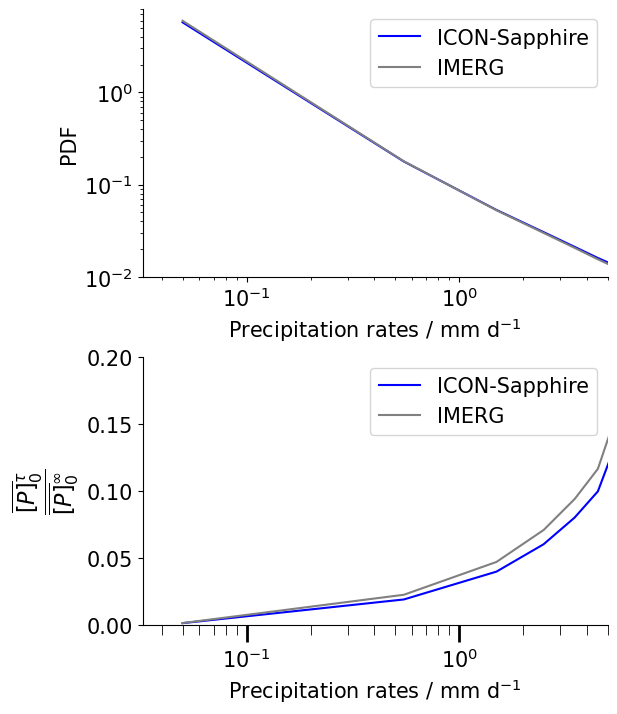

In [114]:
xaxis= (np.array(limits[1:]) - np.array(limits[:-1]))/2+np.array(limits[:-1])
widths= (np.array(limits[1:]) - np.array(limits[:-1]))
fig = plt.figure(figsize=(6, 8),facecolor='white')

### Plot of the PDF of precipitation
ax = fig.add_subplot(211)
ax.plot(xaxis,pdf_icon,'-b',label='ICON-Sapphire')
ax.plot(xaxis,pdf_imerg,'-',color='gray',label='IMERG')
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(labelsize=15)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xlabel('Precipitation rates / mm d$^{-1}$', color='k',fontsize=15)
ax.set_ylabel('PDF', color='k',fontsize=15)
plt.legend(fontsize=15)
ax.set_ylim([1e-2, 8])
ax.set_xlim([0, 5])
### Plot of the accumulative contribution along bins
ax = fig.add_subplot(212)
plot=ax.plot(xaxis,contri_icon,
    color='blue',label='ICON-Sapphire')
plot = ax.plot(
    xaxis,contri_imerg,
    color='gray',label='IMERG')

ax.set_xscale('log');ax.set_ylabel(r"$\dfrac{\overline{[P]}^{\tau}_{0}}{\overline{[P]}^{\infty}_{0}}$",fontsize=16); 
ax.set_xlabel('Precipitation rates / mm d$^{-1}$',fontsize=15);ax.tick_params(labelsize=15)
ax.tick_params(axis='x',which='minor',length=7.5);ax.tick_params(axis='x',which='major',length=12.5,width=2)
plt.legend(fontsize=15)
plt.subplots_adjust(hspace=0.3)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_ylim([0, 0.2])
ax.set_xlim([0, 5])
plt.savefig(
    '/scratch/m/m300876/results/daily_precip/pdf_intensity_cumulative_precip_bins_dpp0066_imerg_zoom_light_precip.png',dpi=400,format='png',\
            bbox_inches='tight',orientation={'landscape'})

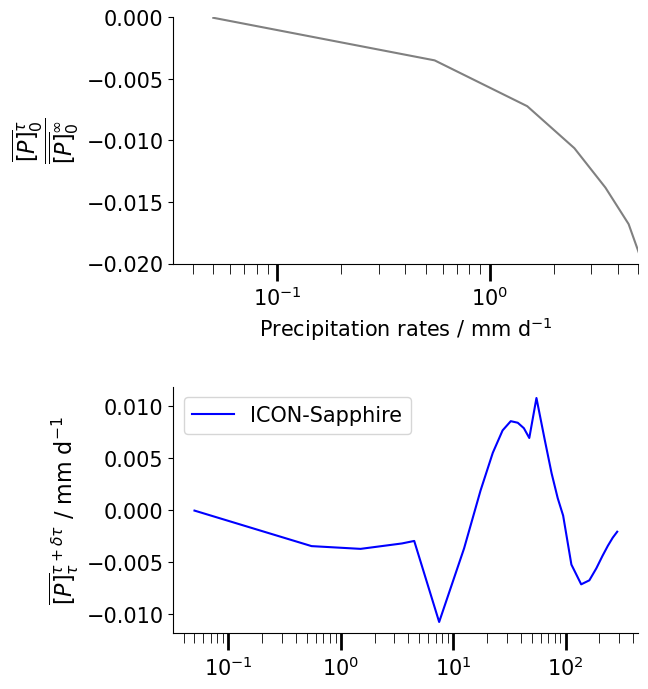

In [115]:
### Plot of the accumulative contribution along bins
xaxis= (np.array(limits[1:]) - np.array(limits[:-1]))/2+np.array(limits[:-1])
widths= (np.array(limits[1:]) - np.array(limits[:-1]))
fig = plt.figure(figsize=(6, 8),facecolor='white')
ax = fig.add_subplot(211)
plot = ax.plot(
    xaxis,contri_icon - contri_imerg,
    color='gray')
ax.set_xscale('log');ax.set_ylabel(r"$\dfrac{\overline{[P]}^{\tau}_{0}}{\overline{[P]}^{\infty}_{0}}$",fontsize=16); 
ax.set_xlabel('Precipitation rates / mm d$^{-1}$',fontsize=15);ax.tick_params(labelsize=15)
ax.tick_params(axis='x',which='minor',length=7.5);ax.tick_params(axis='x',which='major',length=12.5,width=2)
plt.subplots_adjust(hspace=0.5)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xlim([0,5])
ax.set_ylim([-0.02,0])

ax = fig.add_subplot(212)
plot_dpp = ax.plot(
    xaxis,total_precip_icon*24*3600/np.sum(total_area_icon)/np.sum(total_precip_icon*24*3600/np.sum(total_area_icon)) -\
    total_precip_imerg/np.sum(total_area_imerg)/np.sum(total_precip_imerg/np.sum(total_area_imerg)),
    color='blue',label='ICON-Sapphire')
ax.set_xscale('log');ax.set_ylabel(r"$\overline{[P]}^{\tau+\delta{\tau}}_{\tau}$ / mm d$^{-1}$",fontsize=16); 
ax.tick_params(labelsize=15)
ax.tick_params(axis='x',which='minor',length=7.5);ax.tick_params(axis='x',which='major',length=12.5,width=2)
plt.legend(fontsize=15)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.savefig(
    '/scratch/m/m300876/results/daily_precip/diffrences_pdf_intensity_cumulative_precip_bins_dpp0066_imerg_zoom_light_precip.png',dpi=400,format='png',\
            bbox_inches='tight',orientation={'landscape'})


In [66]:
limits_light = np.concatenate((np.arange(0,10.1,0.25),np.array([300])))

In [67]:
pdf_icon_light, _ = histograms_precip(
    file_icon,'pr',['2020-02-01','2021-01-31'],limits_light,environ='trop')

In [68]:
pdf_imerg_light, _ = histograms_precip(
    file_imerg,'calibrated_precipitation',['2020-02-01','2020-12-30'],limits_light,factor=1,environ='trop')

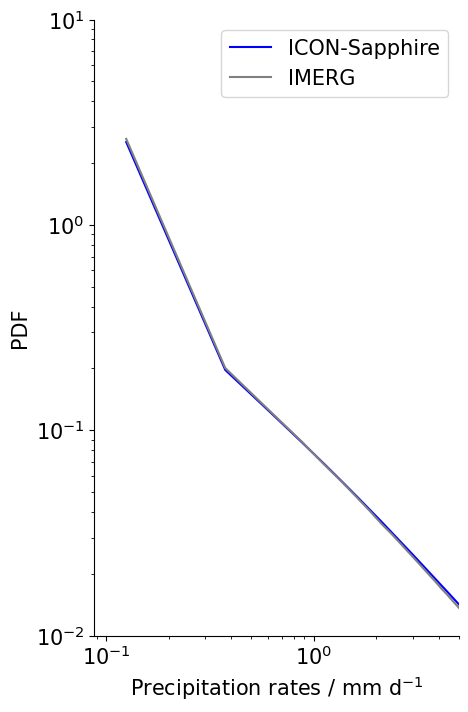

In [72]:
xaxis= (np.array(limits_light[1:]) - np.array(limits_light[:-1]))/2+np.array(limits_light[:-1])
widths= (np.array(limits_light[1:]) - np.array(limits_light[:-1]))
fig = plt.figure(figsize=(16, 8),facecolor='white')

### Plot of the PDF of precipitation
ax = fig.add_subplot(131)
ax.plot(xaxis,pdf_icon_light,'-b',label='ICON-Sapphire')
ax.plot(xaxis,pdf_imerg_light,'-',color='gray',label='IMERG')
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(labelsize=15)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xlabel('Precipitation rates / mm d$^{-1}$', color='k',fontsize=15)
ax.set_ylabel('PDF', color='k',fontsize=15)
plt.legend(fontsize=15)
ax.set_xlim([0, 5])
ax.set_ylim([1e-2, 10])
plt.savefig(
    '/scratch/m/m300876/results/daily_precip/pdf_intensity_dpp0066_imerg_low_percentiles.png',dpi=400,format='png',\
            bbox_inches='tight',orientation={'landscape'})

In [23]:
limits_light_2 = np.arange(0,1,0.05)

In [24]:
pdf_icon_light_2, _ = histograms_precip(
    file_icon,'pr',['2020-02-01','2021-01-31'],limits_light_2,environ='trop')

pdf_imerg_light_2, _ = histograms_precip(
    file_imerg,'calibrated_precipitation',['2020-02-01','2020-12-30'],limits_light_2,factor=1,environ='trop')

In [25]:
xaxis= (np.array(limits_light_2[1:]) - np.array(limits_light_2[:-1]))/2+np.array(limits_light_2[:-1])
widths= (np.array(limits_light_2[1:]) - np.array(limits_light_2[:-1]))
fig = plt.figure(figsize=(16, 8),facecolor='white')

### Plot of the PDF of precipitation
ax = fig.add_subplot(131)
ax.plot(xaxis,pdf_icon_light_2,'-b',label='ICON-Sapphire')
ax.plot(xaxis,pdf_imerg_light_2,'-',color='gray',label='IMERG')
ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(labelsize=15)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xlabel('Precipitation rates / mm d$^{-1}$', color='k',fontsize=15)
ax.set_ylabel('PDF', color='k',fontsize=15)
plt.legend(fontsize=15)
ax.set_xlim([0, 1])

(0.02087035913711543, 1)